In [1]:
!pip install shap --quiet
!pip install scikit-learn pandas numpy matplotlib seaborn --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)
from sklearn.preprocessing import LabelEncoder

print("✅ All imports successful")

✅ All imports successful


In [13]:
df1 = pd.read_csv('flood_training_data.csv')
df2 = pd.read_csv('flood_training_data_2025.csv')
df  = pd.concat([df1, df2], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
df.to_csv('flood_training_combined.csv', index=False)
print(df.shape)

df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"\n✅ Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nClass Distribution:")
label_map = {0: 'LOW', 1: 'MODERATE', 2: 'HIGH', 3: 'CRITICAL'}
counts = df['risk_label'].value_counts().sort_index()
for label, count in counts.items():
    pct = count / len(df) * 100
    print(f"  {label_map[label]:10s} ({label}): {count} rows  ({pct:.1f}%)")

print("\nSample Data:")
df.head()

(2000, 13)

✅ Dataset loaded: 2000 rows × 13 columns

Class Distribution:
  LOW        (0): 800 rows  (40.0%)
  MODERATE   (1): 600 rows  (30.0%)
  HIGH       (2): 400 rows  (20.0%)
  CRITICAL   (3): 200 rows  (10.0%)

Sample Data:


,timestamp,distance_cm,rain_analog,float_status,rise_rate_cm_per_min,rain_trend_5min,distance_rolling_mean_3min,distance_rolling_std_3min,cumulative_rain_30min,time_since_rain_start,emergency_flag,season_flag,risk_label
0,2025-03-07 19:53:00,56.61,394,0,-0.6135,396.4,55.8246,0.7200,113.07,37,0,0,1
1,2024-07-01 03:09:00,120.60,252,0,0.0963,247.8,120.7174,0.1040,24.63,6,0,1,0
2,2025-03-18 05:32:00,65.29,345,0,-1.2925,344.4,63.9126,1.1666,41.79,0,0,0,1
3,2024-07-02 03:15:00,56.66,594,0,-2.0679,585.2,55.7210,0.8543,143.67,15,0,1,1
4,2025-05-20 00:51:00,123.31,167,0,-1.8383,132.2,121.6984,1.2311,18.89,42,0,0,0


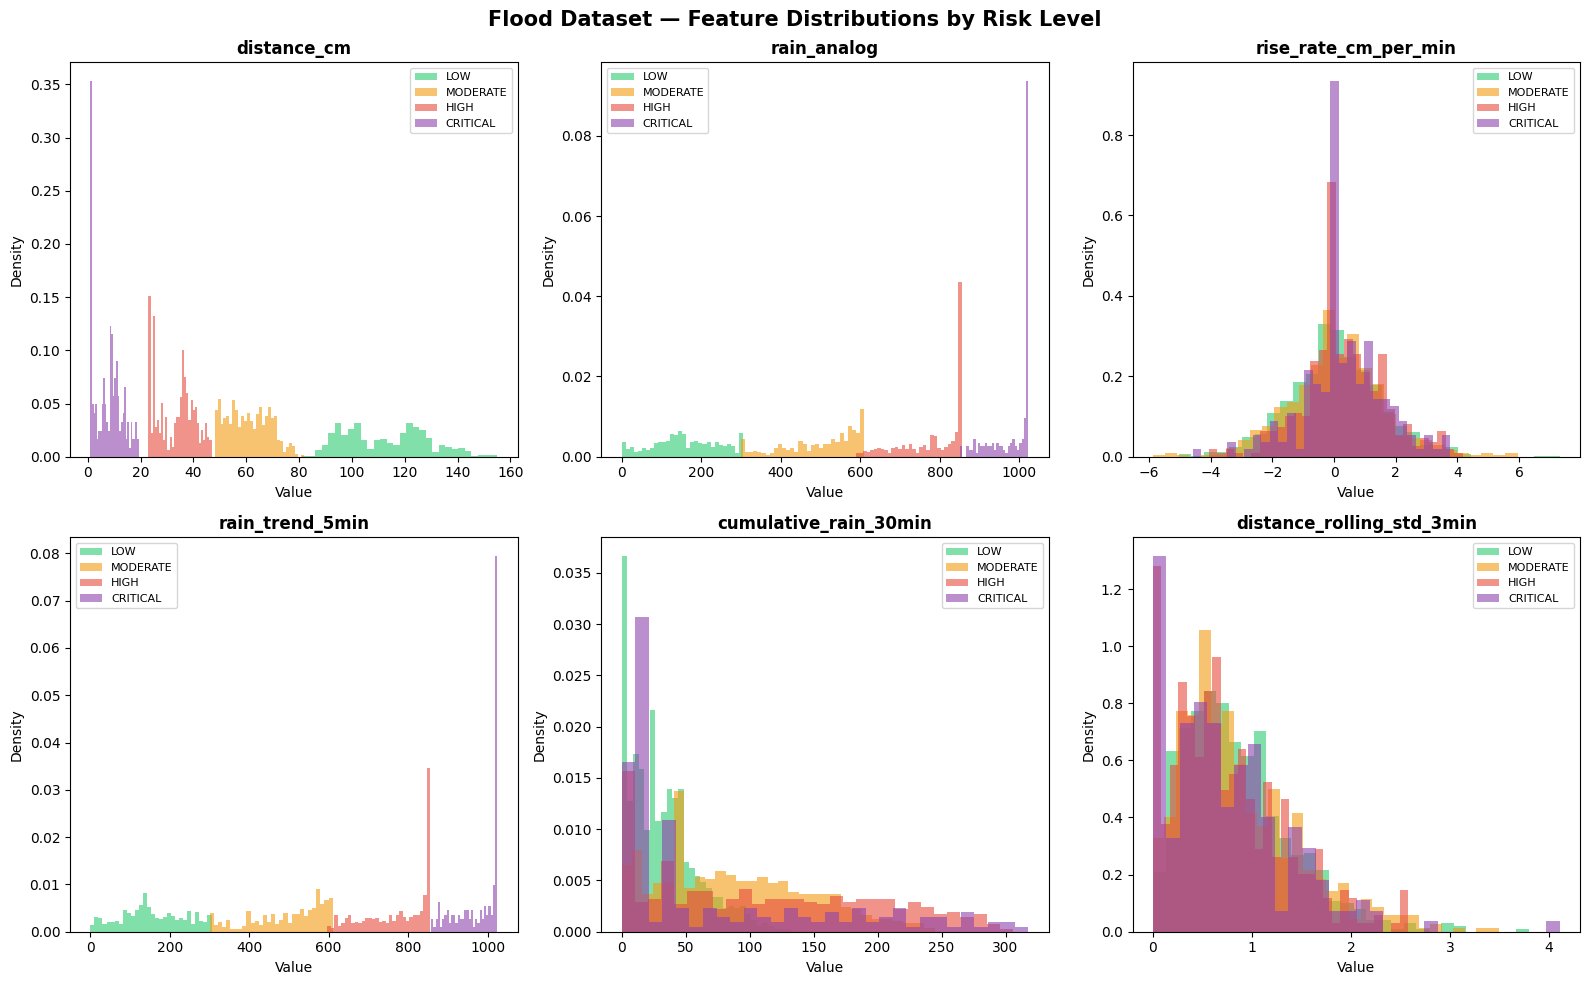

✅ EDA plot saved


In [14]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Flood Dataset — Feature Distributions by Risk Level', fontsize=15, fontweight='bold')

features_to_plot = [
    'distance_cm', 'rain_analog', 'rise_rate_cm_per_min',
    'rain_trend_5min', 'cumulative_rain_30min', 'distance_rolling_std_3min'
]
colors = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad']
label_names = ['LOW', 'MODERATE', 'HIGH', 'CRITICAL']

for ax, feature in zip(axes.flatten(), features_to_plot):
    for label in range(4):
        subset = df[df['risk_label'] == label][feature]
        ax.hist(subset, bins=30, alpha=0.6, color=colors[label],
                label=label_names[label], density=True)
    ax.set_title(feature, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('eda_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ EDA plot saved")

In [15]:
# Extract temporal features from timestamp
# Raw datetime is meaningless to Random Forest — extract cyclical signals instead
df['hour_of_day']  = df['timestamp'].dt.hour        # 0–23  (night vs day rain patterns)
df['day_of_week']  = df['timestamp'].dt.dayofweek   # 0=Mon … 6=Sun
df['month']        = df['timestamp'].dt.month       # 1–12  (seasonal context)
# Note: season_flag already captures monsoon — month adds finer granularity

# Drop raw timestamp and any ID columns — never feed these to the model
df.drop(columns=['timestamp'], inplace=True, errors='ignore')
df.drop(columns=['id'], inplace=True, errors='ignore')

FEATURES = [
    'distance_cm',
    'rain_analog',
    'float_status',
    'rise_rate_cm_per_min',
    'rain_trend_5min',
    'distance_rolling_mean_3min',
    'distance_rolling_std_3min',
    'cumulative_rain_30min',
    'time_since_rain_start',
    'emergency_flag',
    'season_flag',
    'hour_of_day',
    'day_of_week',
    'month'
]
TARGET = 'risk_label'

X = df[FEATURES]
y = df[TARGET]

# Check for nulls
null_counts = X.isnull().sum()
if null_counts.sum() > 0:
    print("⚠️ Null values found — filling with column medians")
    X = X.fillna(X.median())
else:
    print("✅ No null values found")

# Train / Test split — stratified to preserve class ratios
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTraining set : {X_train.shape[0]} rows")
print(f"Test set     : {X_test.shape[0]} rows")
print(f"\n✅ Features used: {FEATURES}")

✅ No null values found

Training set : 1600 rows
Test set     : 400 rows

✅ Features used: ['distance_cm', 'rain_analog', 'float_status', 'rise_rate_cm_per_min', 'rain_trend_5min', 'distance_rolling_mean_3min', 'distance_rolling_std_3min', 'cumulative_rain_30min', 'time_since_rain_start', 'emergency_flag', 'season_flag', 'hour_of_day', 'day_of_week', 'month']


In [16]:
rf_model = RandomForestClassifier(
    n_estimators=200,          # Reduced — 300 is overkill for 1000 rows
    max_depth=12,              # 🔑 Hard cap — prevents trees memorizing every row
    min_samples_split=10,      # 🔑 Need 10 samples to make a split (was 5)
    min_samples_leaf=5,        # 🔑 Each leaf needs 5 samples minimum (was 2)
    max_features='sqrt',       # Standard for classification
    max_samples=0.8,           # 🔑 Each tree sees only 80% of data (adds variance)
    class_weight='balanced',   # Handles CRITICAL being only 10%
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest (with overfitting constraints)...")
rf_model.fit(X_train, y_train)
print("✅ Training complete!")

# Train vs Test accuracy — gap reveals overfitting
train_acc = accuracy_score(y_train, rf_model.predict(X_train))
test_acc  = accuracy_score(y_test,  rf_model.predict(X_test))
gap = train_acc - test_acc

print(f"\nTrain Accuracy : {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Test  Accuracy : {test_acc:.4f}  ({test_acc*100:.2f}%)")
print(f"Gap            : {gap:.4f}  ", end="")
if gap < 0.05:
    print("✅ Healthy — model is generalizing")
elif gap < 0.10:
    print("Mild overfit — acceptable for synthetic data")
else:
    print("Overfitting — increase min_samples_leaf or reduce max_depth")

# 5-fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')
print(f"\nCross-Val Accuracy : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"   Fold scores       : {[round(s, 4) for s in cv_scores]}")


Training Random Forest (with overfitting constraints)...
✅ Training complete!

Train Accuracy : 1.0000 (100.00%)
Test  Accuracy : 1.0000  (100.00%)
Gap            : 0.0000  ✅ Healthy — model is generalizing

Cross-Val Accuracy : 1.0000 ± 0.0000
   Fold scores       : [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


Test Accuracy: 1.0000 (100.00%)

Classification Report:
              precision    recall  f1-score   support

         LOW       1.00      1.00      1.00       160
    MODERATE       1.00      1.00      1.00       120
        HIGH       1.00      1.00      1.00        80
    CRITICAL       1.00      1.00      1.00        40

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



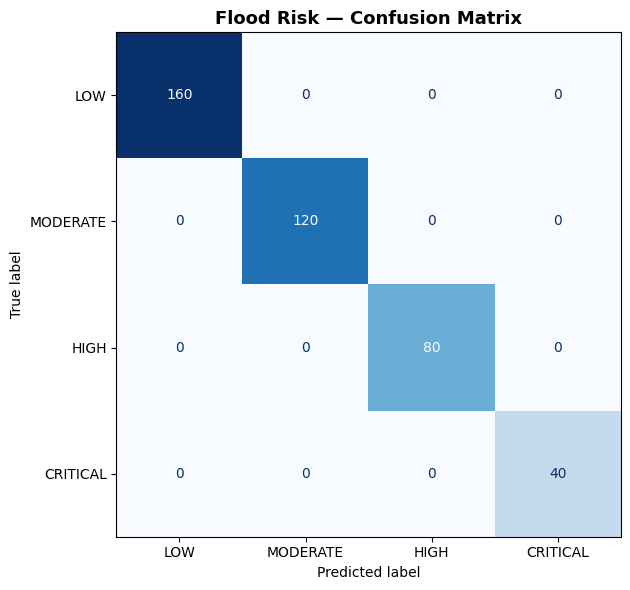

✅ Confusion matrix saved


In [17]:
y_pred = rf_model.predict(X_test)

# Overall accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f} ({acc*100:.2f}%)\n")

# Per-class report
print("Classification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=['LOW', 'MODERATE', 'HIGH', 'CRITICAL']
))

# Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['LOW', 'MODERATE', 'HIGH', 'CRITICAL']
)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Flood Risk — Confusion Matrix', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Confusion matrix saved")

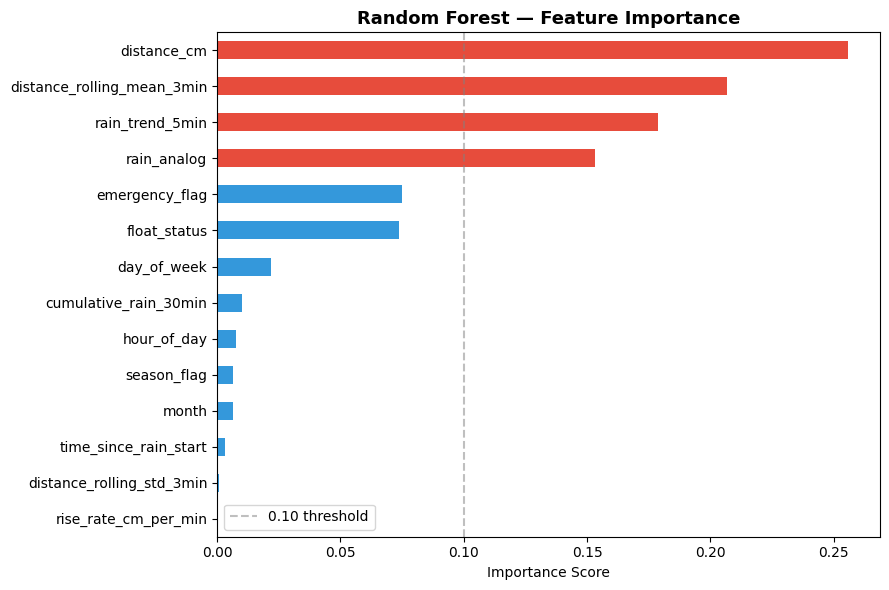


Top Features:
  distance_cm                         0.2560  █████████████████████████
  distance_rolling_mean_3min          0.2067  ████████████████████
  rain_trend_5min                     0.1786  █████████████████
  rain_analog                         0.1534  ███████████████
  emergency_flag                      0.0749  ███████
  float_status                        0.0738  ███████
  day_of_week                         0.0218  ██
  cumulative_rain_30min               0.0101  █
  hour_of_day                         0.0077  
  season_flag                         0.0065  
  month                               0.0063  
  time_since_rain_start               0.0033  
  distance_rolling_std_3min           0.0007  
  rise_rate_cm_per_min                0.0003  


In [18]:
importances = pd.Series(rf_model.feature_importances_, index=FEATURES)
importances = importances.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(9, 6))
colors_bar = ['#e74c3c' if v > 0.15 else '#3498db' for v in importances.values]
importances.plot(kind='barh', ax=ax, color=colors_bar)
ax.set_title('Random Forest — Feature Importance', fontsize=13, fontweight='bold')
ax.set_xlabel('Importance Score')
ax.axvline(x=0.1, color='gray', linestyle='--', alpha=0.5, label='0.10 threshold')
ax.legend()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop Features:")
for feat, score in importances.sort_values(ascending=False).items():
    bar = '█' * int(score * 100)
    print(f"  {feat:35s} {score:.4f}  {bar}")

🔍 Computing SHAP values (this may take ~30 seconds)...
✅ SHAP values computed — shape per class: (400, 14)
   Classes: 4 | Features: 14 | Samples: 400

Generating SHAP Summary Plot...


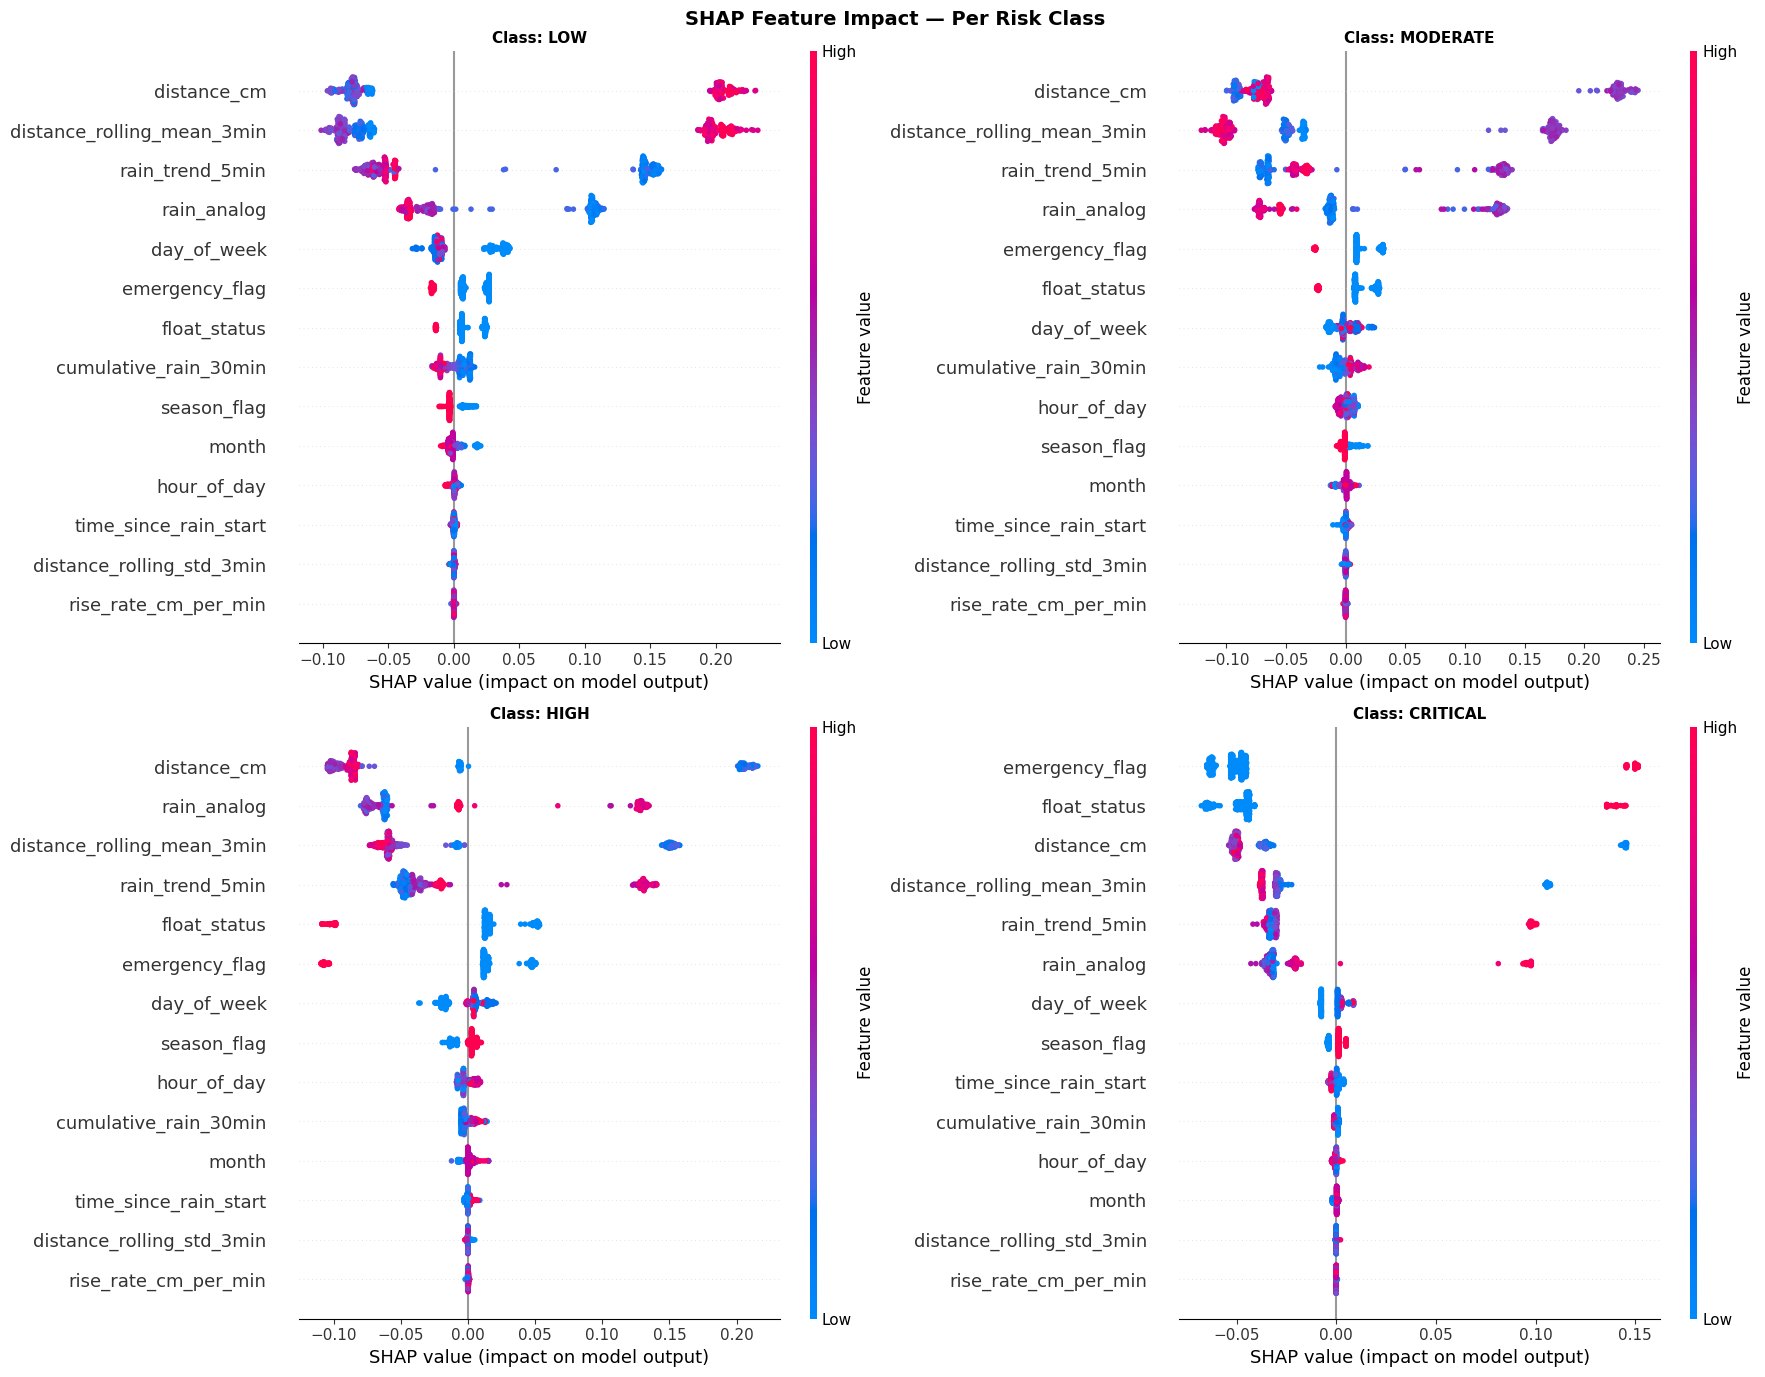

✅ SHAP summary saved


In [19]:
print("🔍 Computing SHAP values (this may take ~30 seconds)...")

explainer = shap.TreeExplainer(rf_model)

# Use a numpy array — avoids shape mismatch between DataFrame and SHAP internals
X_test_array = X_test.values
shap_values = explainer.shap_values(X_test_array)

# shap_values shape: (n_classes, n_samples, n_features)
# Normalize to always be a list of 2D arrays — handles both old and new SHAP versions
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    shap_values = [shap_values[:, :, i] for i in range(shap_values.shape[2])]
    # now shap_values[class] = (n_samples, n_features) ✅

print(f"✅ SHAP values computed — shape per class: {shap_values[0].shape}")
print(f"   Classes: {len(shap_values)} | Features: {shap_values[0].shape[1]} | Samples: {shap_values[0].shape[0]}")

# SHAP Summary Plot — one subplot per class
print("\nGenerating SHAP Summary Plot...")
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('SHAP Feature Impact — Per Risk Class', fontsize=14, fontweight='bold')

class_names = ['LOW', 'MODERATE', 'HIGH', 'CRITICAL']
for i, (ax, name) in enumerate(zip(axes.flatten(), class_names)):
    plt.sca(ax)
    shap.summary_plot(
        shap_values[i],          # (n_samples, n_features) — correct shape ✅
        X_test_array,            # numpy array — no shape mismatch ✅
        feature_names=FEATURES,
        show=False,
        plot_type='dot',         # 'dot' is more stable than 'violin' across SHAP versions
        plot_size=None,
        max_display=14
    )
    ax.set_title(f'Class: {name}', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ SHAP summary saved")

Sample #145 Prediction
   Predicted Risk : CRITICAL (Class 3)

   Probabilities:
   LOW       : 0.000  
   MODERATE  : 0.000  
   HIGH      : 0.000  
   CRITICAL  : 1.000  ████████████████████████████████████████

   Sensor Readings:
   distance_cm                        : 14.22
   rain_analog                        : 1023.0
   float_status                       : 1.0
   rise_rate_cm_per_min               : -1.5125
   rain_trend_5min                    : 1021.6
   distance_rolling_mean_3min         : 13.479
   distance_rolling_std_3min          : 0.6177
   cumulative_rain_30min              : 101.97
   time_since_rain_start              : 6.0
   emergency_flag                     : 1.0
   season_flag                        : 1.0
   hour_of_day                        : 22.0
   day_of_week                        : 1.0
   month                              : 7.0

SHAP Explanation → why CRITICAL:


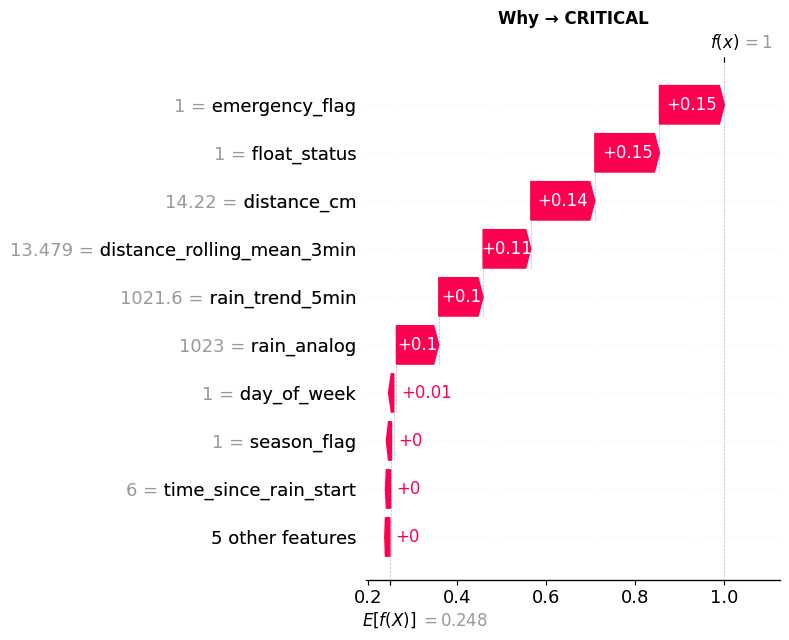

✅ SHAP waterfall saved


In [21]:
SAMPLE_INDEX = 145

sample_array = X_test_array[[SAMPLE_INDEX]]   # numpy array, shape (1, n_features)
prediction   = rf_model.predict(sample_array)[0]
probabilities = rf_model.predict_proba(sample_array)[0]

print(f"Sample #{SAMPLE_INDEX} Prediction")
print(f"   Predicted Risk : {label_map[prediction]} (Class {prediction})")
print(f"\n   Probabilities:")
for i, prob in enumerate(probabilities):
    bar = '█' * int(prob * 40)
    print(f"   {label_map[i]:10s}: {prob:.3f}  {bar}")

print(f"\n   Sensor Readings:")
for col, val in zip(FEATURES, X_test_array[SAMPLE_INDEX]):
    print(f"   {col:35s}: {val}")

# Waterfall — uses pre-computed shap_values from Cell 9
print(f"\nSHAP Explanation → why {label_map[prediction]}:")
shap_exp = shap.Explanation(
    values=shap_values[prediction][SAMPLE_INDEX],        # 1D array of feature contributions
    base_values=explainer.expected_value[prediction],
    data=X_test_array[SAMPLE_INDEX],
    feature_names=FEATURES
)
shap.plots.waterfall(shap_exp, show=False)
plt.title(f'Why → {label_map[prediction]}', fontweight='bold')
plt.tight_layout()
plt.savefig('shap_waterfall.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ SHAP waterfall saved")

In [22]:
# Save model
MODEL_PATH = 'flood_model.pkl'
with open(MODEL_PATH, 'wb') as f:
    pickle.dump(rf_model, f)

# Save metadata (feature list + label map — critical for inference)
META_PATH = 'flood_model_meta.pkl'
meta = {
    'features': FEATURES,
    'label_map': label_map,
    'model_type': 'RandomForestClassifier',
    'n_estimators': rf_model.n_estimators,
    'cv_accuracy': cv_scores.mean()
}
with open(META_PATH, 'wb') as f:
    pickle.dump(meta, f)

print("✅ Model exported successfully!")
print(f"   {MODEL_PATH}     — the trained model")
print(f"   {META_PATH} — feature list + label map")

# Download files
from google.colab import files
files.download(MODEL_PATH)
files.download(META_PATH)

✅ Model exported successfully!
   flood_model.pkl     — the trained model
   flood_model_meta.pkl — feature list + label map


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# Simulate what real-time prediction will look like

def predict_flood_risk(sensor_reading: dict, model, meta) -> dict:
    """
    sensor_reading: dict with current sensor values
    Returns: prediction label + probabilities
    """
    row = pd.DataFrame([sensor_reading])[meta['features']]
    pred_class = model.predict(row)[0]
    pred_proba = model.predict_proba(row)[0]

    return {
        'risk_level': meta['label_map'][pred_class],
        'risk_class': int(pred_class),
        'confidence': round(float(pred_proba[pred_class]) * 100, 1),
        'probabilities': {
            meta['label_map'][i]: round(float(p) * 100, 1)
            for i, p in enumerate(pred_proba)
        }
    }

# --- Test with a CRITICAL scenario ---
# Simulate: 2am, Tuesday, August (peak monsoon night)
critical_reading = {
    'distance_cm': 12.5,
    'rain_analog': 920,
    'float_status': 1,
    'rise_rate_cm_per_min': 4.8,
    'rain_trend_5min': 890.0,
    'distance_rolling_mean_3min': 15.0,
    'distance_rolling_std_3min': 2.1,
    'cumulative_rain_30min': 450.0,
    'time_since_rain_start': 55,
    'emergency_flag': 1,
    'season_flag': 1,
    'hour_of_day': 2,       # 2am
    'day_of_week': 1,       # Tuesday (0=Mon)
    'month': 8              # August — peak monsoon
}

# --- Test with a LOW scenario ---
# Simulate: 10am, Monday, February (dry season morning)
low_reading = {
    'distance_cm': 105.0,
    'rain_analog': 150,
    'float_status': 0,
    'rise_rate_cm_per_min': 0.1,
    'rain_trend_5min': 140.0,
    'distance_rolling_mean_3min': 106.0,
    'distance_rolling_std_3min': 0.5,
    'cumulative_rain_30min': 10.0,
    'time_since_rain_start': 5,
    'emergency_flag': 0,
    'season_flag': 0,
    'hour_of_day': 10,      # 10am
    'day_of_week': 0,       # Monday
    'month': 2              # February — dry season
}

# Load freshly from disk to verify pkl works
with open('flood_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
with open('flood_model_meta.pkl', 'rb') as f:
    loaded_meta = pickle.load(f)

result_critical = predict_flood_risk(critical_reading, loaded_model, loaded_meta)
result_low      = predict_flood_risk(low_reading,      loaded_model, loaded_meta)

print("CRITICAL scenario result:")
print(f"   Risk Level  : {result_critical['risk_level']}")
print(f"   Confidence  : {result_critical['confidence']}%")
print(f"   Probabilities: {result_critical['probabilities']}")

print("\nLOW scenario result:")
print(f"   Risk Level  : {result_low['risk_level']}")
print(f"   Confidence  : {result_low['confidence']}%")
print(f"   Probabilities: {result_low['probabilities']}")

CRITICAL scenario result:
   Risk Level  : CRITICAL
   Confidence  : 98.2%
   Probabilities: {'LOW': 0.0, 'MODERATE': 0.0, 'HIGH': 1.8, 'CRITICAL': 98.2}

LOW scenario result:
   Risk Level  : LOW
   Confidence  : 100.0%
   Probabilities: {'LOW': 100.0, 'MODERATE': 0.0, 'HIGH': 0.0, 'CRITICAL': 0.0}
